In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [48]:
movies = pd.read_csv('../data/imdb-cleaned.csv')

In [49]:
movies['total_votes'] = movies.loc[:, 'rating_1':'rating_10'].sum(axis='columns')

We made a variable `total_votes` with the total number of user votes.

In [50]:
def calc_unweighted_rating(row):
    return sum([i * row[f'rating_{i}'] for i in range(1, 11)]) / row['total_votes']

movies['unweighted_rating'] = movies.apply(calc_unweighted_rating, axis='columns')

In [51]:
def calc_polarization(row):
    total_score = 0
    for rating_1 in range(1, 11):
        for rating_2 in range(rating_1 + 1, 11):
            total_score += row[f'rating_{rating_1}'] / row['total_votes'] * row[f'rating_{rating_2}'] / row['total_votes'] * (rating_2 - rating_1)

    return total_score

In [52]:
movies['polarization_score'] = movies.apply(calc_polarization, axis='columns')

We made a variable `polarization_score` with the polarization score calculated using Esteban and Ray's algorithm.

In [53]:
def calc_country_rating(country_idx, row):
    total_rating = 0
    total_votes = 0
    for rating in range(1, 11):
        total_rating += rating * row[f'country_{country_idx}_rating_{rating}']
        total_votes += row[f'country_{country_idx}_rating_{rating}']
    return total_rating / total_votes

In [54]:
for i in range(5):
    movies[f'country_{i}_rating'] = movies.apply(lambda row: calc_country_rating(i, row), axis='columns')

In [55]:
def calc_ptp(row):
    ptp = np.ptp(row.loc['country_0_rating':'country_4_rating'])

    max_country_idx = np.argmax(row.loc['country_0_rating':'country_4_rating'])
    min_country_idx = np.argmin(row.loc['country_0_rating':'country_4_rating'])
    max_country = row[f'country_{max_country_idx}']
    min_country = row[f'country_{min_country_idx}']
    
    return pd.Series([ptp, max_country, min_country])

In [56]:
movies[['country_ptp', 'max_country_ptp', 'min_country_ptp']] = movies.apply(calc_ptp, axis='columns')

We made a variable `country_ptp` with the difference between the highest and lowest average ratings between the top five countries with the most votes. The variables `max_country_ptp` and `min_country_ptp` record the country codes of the two countries with the highest and lowest ratings, respectively.

# EDA

In [57]:
movies.sort_values('country_ptp', ascending=False).head(25)

,id,title,genres,weighted_rating,release_year,rating_1,rating_2,rating_3,rating_4,rating_5,...,unweighted_rating,polarization_score,country_0_rating,country_1_rating,country_2_rating,country_3_rating,country_4_rating,country_ptp,max_country_ptp,min_country_ptp
3314,tt4776998,The Promise,"Action,Adventure,Drama",6.1,2017,71664,785,464,775,1792,...,6.016163,2.203718,8.853424,1.372856,9.621135,7.973952,9.920069,8.547214,AM,TR
4299,tt11555492,Farha,Drama,8.0,2022,9534,177,97,127,268,...,8.871703,0.981824,9.418896,2.721110,9.675454,9.617452,9.901685,7.180575,JO,IL
4326,tt7668842,Enes Batur: Imagination or Reality?,Comedy,2.0,2018,21542,748,526,347,471,...,6.229664,2.186839,5.369399,3.201413,7.219048,3.030189,9.915730,6.885542,MY,GB
4322,tt10554232,Dara of Jasenovac,"Drama,War",8.1,2021,3818,262,176,200,350,...,9.395185,0.560421,9.872591,9.197059,9.094617,9.785560,3.023002,6.849588,RS,HR
4314,tt27719898,Kaiva,"Action,Drama,Romance",8.5,2023,7908,1162,16,28,37,...,8.598857,1.159006,8.632270,5.288793,7.434343,2.772727,2.846154,5.859543,IN,CA
4271,tt15979666,The Archies,"Comedy,Drama,Musical",4.2,2023,7096,918,579,601,754,...,8.019633,1.472463,8.523331,3.764650,3.804031,4.066975,3.327014,5.196317,IN,CA
2683,tt0077928,Midnight Express,"Biography,Crime,Drama",7.5,1978,5628,684,675,1175,2725,...,7.295586,1.065465,7.436350,7.554844,3.224610,8.212210,7.648483,4.987600,GR,TR
4272,tt9637132,Samrat Prithviraj,"Action,Drama,History",5.6,2022,7574,964,586,637,927,...,7.959218,1.497891,8.384095,5.233802,5.597938,3.492119,4.573034,4.891976,IN,BD
7,tt20221436,Emilia Pérez,"Comedy,Crime,Drama",5.5,2024,24930,3995,3366,3753,5153,...,4.491042,1.737361,4.775475,2.465527,1.949050,5.211796,6.801721,4.852670,FR,MX
4328,tt10280276,Coolie No. 1,"Action,Comedy,Romance",4.2,2020,46055,1455,760,576,525,...,3.828636,1.910510,3.133739,6.429201,1.851842,4.394161,1.663772,4.765429,US,CA


In [58]:
movies = movies.sort_values('polarization_score', ascending=False)

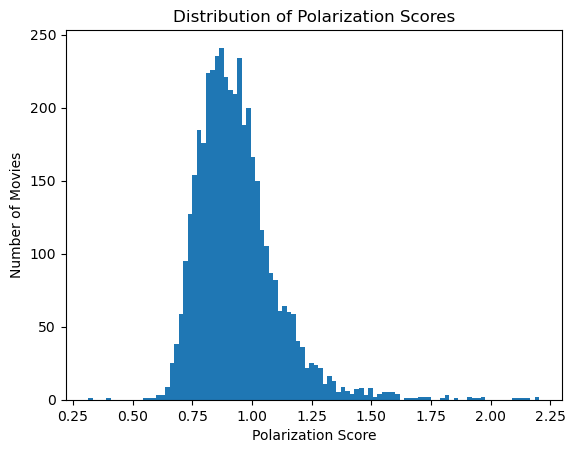

In [59]:
plt.hist(movies['polarization_score'], bins=100)
plt.xlabel('Polarization Score')
plt.ylabel('Number of Movies')
plt.title('Distribution of Polarization Scores')
plt.show()

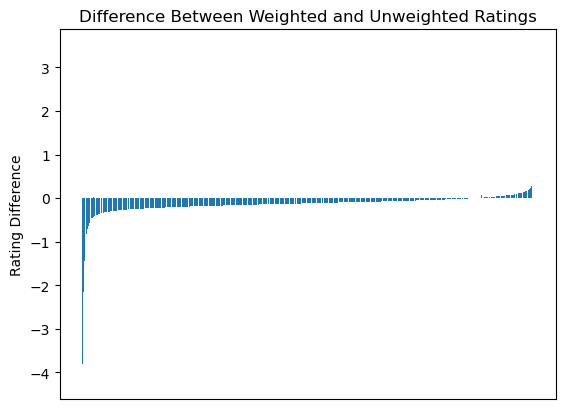

In [69]:
movies['rating_diff'] = movies['weighted_rating'] - movies['unweighted_rating']
sorted_movies = movies.sort_values('rating_diff', ascending=True)

plt.bar(sorted_movies['title'], sorted_movies['rating_diff'])
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.ylabel('Rating Difference')
plt.title('Difference Between Weighted and Unweighted Ratings')
plt.show()

In [61]:
movies

,id,title,genres,weighted_rating,release_year,rating_1,rating_2,rating_3,rating_4,rating_5,...,polarization_score,country_0_rating,country_1_rating,country_2_rating,country_3_rating,country_4_rating,country_ptp,max_country_ptp,min_country_ptp,rating_diff
4326,tt7668842,Enes Batur: Imagination or Reality?,Comedy,2.0,2018,21542,748,526,347,471,...,2.186839,5.369399,3.201413,7.219048,3.030189,9.915730,6.885542,MY,GB,-4.229664
4271,tt15979666,The Archies,"Comedy,Drama,Musical",4.2,2023,7096,918,579,601,754,...,1.472463,8.523331,3.764650,3.804031,4.066975,3.327014,5.196317,IN,CA,-3.819633
4305,tt12915716,Adipurush,"Action,Drama",2.7,2023,51121,3081,1575,1054,1077,...,2.120026,6.059150,2.978719,2.793604,2.145765,1.755344,4.303805,IN,NP,-2.983395
4325,tt8426926,Shamshera,"Action,Adventure,Drama",4.7,2022,10544,1220,733,744,1002,...,1.614037,7.466221,5.546586,4.278287,5.520211,3.894198,3.572023,IN,CA,-2.447329
2641,tt28075881,Do Patti,"Crime,Drama,Mystery",6.4,2024,1194,429,454,682,1284,...,0.777627,9.037616,5.810345,5.800000,5.911162,5.843844,3.237616,IN,GB,-2.409863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4172,tt10028196,Laal Singh Chaddha,"Comedy,Drama,Romance",5.6,2022,97775,4265,1436,973,1495,...,2.107484,4.301501,4.416682,4.431414,6.135055,6.526270,2.224769,BD,IN,1.106702
4106,tt10083340,Gangubai Kathiawadi,"Biography,Crime,Drama",7.8,2022,16466,1161,763,856,1517,...,1.976030,6.387462,6.406269,5.928605,7.042885,7.417170,1.488566,PK,GB,1.355617
2127,tt1289401,Ghostbusters,"Action,Comedy,Fantasy",6.8,2016,43927,13107,14645,20793,33093,...,1.586990,5.423845,5.183479,5.292190,4.721310,5.266602,0.702535,US,DE,1.585510
567,tt5971474,The Little Mermaid,"Adventure,Family,Fantasy",7.2,2023,42723,8622,6100,6535,11339,...,1.822957,5.656948,5.599737,5.414780,5.733976,4.665881,1.068096,BR,DE,1.970611
